# Ramping tests

**AIM**: To find the appropriate ramp slope for P1 that keeps the gate voltage "constant".

Based upon `june/toolkit_example_code/psb_gate_sequence.ipynb` which is based upon `june/toolkit_example_code/lf_st_sweep.ipynb` respectively

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
from zhinst.toolkit import Session, CommandTable, Sequence, Waveforms, SHFQAChannelMode

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import time
from monty import Monty

## Setup

In [3]:
# connect to instruments

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

# connect to data server
session = Session(SERVER_HOST)

# connect to device
device = session.connect_device(DEVICE_ID)

In [4]:
#session.disconnect_device(DEVICE_ID)

### Variables

In [5]:
NUM_READOUTS = 5

# gate sampling time
samplingDivider = 3  # BE AWARE IF THIS CHANGES THAT YOU NEED TO UPDATE AWG_RATE_250MHZ IN PLAYZERO COMMANDS

# readout signals
readout_gain = 0.95
readout_freq = 406.6e6

# drive line amplitudes (maximum 340mV, give in terms of V)
init_amp = 0.02 * 10  # *10 compensates weird quirk between interaction of voltToDbm function, pulseAndRamp array, and SHFQC behaviour...
read_amp = 0.02 * 10
read_amp_j = 0.2

ramp_rate = 6.8e-6  # hopefully this is calibrated to 250 MHz sample rate (V/s)
num_pulses = 5  # number of unique waveforms to generate


# timings in seconds
wait_and_settle = 100e-6  # C time
prior_delay = 10e-6  # A time
init_len = 10e-6       # starting P1/P2 pulse length (B time)
read_len = 10e-6       # readout pulse length (D time)

### Functions

In [6]:
def timeToSamples(time, samplingRateDivider):
    # returns the number of samples divisible by 16 given a time (in seconds) and sampling rate divider
    samples_raw = time * (1/(2**samplingRateDivider))/0.5e-9
    samples_modulo = int(samples_raw) % 16
    samples = int(samples_raw) - int(samples_modulo)
    return samples

def voltToDbm(volt, dbmrange):
    '''WIP. Returns a normalized amplitude given a dBm output range. 
    Calibrated using scope, and doing it a shit way (not real conversion).
    See page 47 of manual.
    Volts given in units of V.
    There is an odd bug (feature?) here, where if the amplitude exceeds 1 (e.g. 1.1), it wraps around and becomes -0.1, 
    and 2.1 becomes 0.1 etc.
    This shouldn't be a problem, but it manifests in the pulseAndRamp array as this takes default values of 0.34V for 1:1
    scaling, flipping P1 and P2 voltages around.
    The fix is to decrease the default values down by 10x, and increase input voltages 10x, and everything is happy.
    If you want to change this to a more sane method, go ahead.'''
    amp = volt / 0.340
    # if volt > 0.340 or volt < -0.340:
    #     raise ValueError("Given voltage is greater than max output of SHFQC (+-0.34 V)")
    if dbmrange != 0:
        raise Exception("This function only works with a dBm range of 0.")
    return amp

def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1:  # readout 1 point
                wave_data_captured[node] = True
                # total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

### Setup channels

In [7]:
# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "P1": device.sgchannels[1],  # drive P1 line
    "P2": device.sgchannels[2],  # drive P2 line
}

drive_chans = ["P1", "P2"]  # match keys above

In [8]:
with device.set_transaction():
    for c in drive_chans:
        chan[c].output.range(0)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
        chan[c].output.on(1)  # enable output
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        chan[c].marker.source(0)  # setup the AWG trigger 1 (is this an input trigger option? doesn't seem necessary)
        # see manual page p235 for all trigger options
        chan[c].awg.auxtriggers[0].channel(8)  # 8=use internal trigger, 1024=use software trigger

    chan["measure"].output.rflfpath(0)  # use LF mode not RF (for signals under 600Mhz)
    chan["measure"].input.rflfpath(0)
    chan["measure"].oscs[0].freq(406.6e6)  # CW frequency (in LF mode)
    chan["measure"].oscs[0].gain(0.95)  # If we set this to 1, then output overloads

    # configure these based on how the sweeper works internally
    # See https://docs.zhinst.com/zhinst-utils/en/latest/_modules/zhinst/utils/shf_sweeper.html#ShfSweeper
    chan["measure"].spectroscopy.delay(0)  # integration delay in units of second
    chan["measure"].spectroscopy.length(timeToSamples(read_len, samplingDivider))  # integration time length in units of number of samples (usually  integration_time*sampling_rate)
    # setup when the spectroscopy is triggered
    chan["measure"].spectroscopy.trigger.channel("chan0seqtrig0")  # make sure to use the trigger coming from the sequencer code
    # setup result parameters
    chan["measure"].spectroscopy.result.averages(1)  # number of averages (always average in software not hardware)
    chan["measure"].spectroscopy.result.length(num_pulses)  # number of results
    chan["measure"].spectroscopy.result.enable(0)  # disable result logger

    chan["measure"].configure_channel(
        center_frequency=0,  # in units of Hz  # minimum of 600MHz
        input_range=-20,  # in units of dBm
        output_range=-20,  # in units of dBm
        mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
    )
    
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)

    chan["measure"].generator.auxtriggers[1].channel("inttrig")

    chan["measure"].generator.configure_sequencer_triggering(
        aux_trigger=8,  # alternatively use 8=internal trigger, or "software_trigger0" to use the software triggering system
        play_pulse_delay=0
    )


In [9]:
init_amp = voltToDbm(0.034, 0)

pulse_lens = np.linspace(10e-6, 100e-6, num_pulses)

# define waveforms as list of real-values arrays
waves = []
for p_len in pulse_lens:
    samples = timeToSamples(p_len, samplingDivider)
    waves.append(np.linspace(init_amp, init_amp+init_amp*samples*ramp_rate, samples))

# upload waveforms to instrument

waveforms = Waveforms()
for i, wave in enumerate(waves):
    waveforms[i] = wave

# upload with sequence code as the memory must be allocated first
#chan["P1"].awg.write_to_waveform_memory(waveforms)
#chan["P2"].awg.write_to_waveform_memory(waveforms)

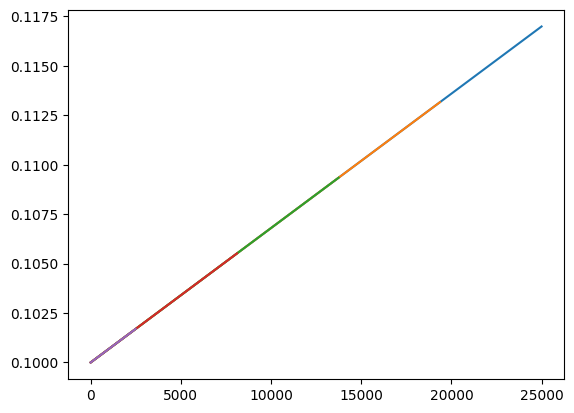

In [10]:
# sanity check
waves.reverse()
for i in waves:
    plt.plot(i)

### Define sequences

In [11]:
# use the same waveforms for all sequence programs
p_prog_code = f"""
// Reset the oscillator phase
resetOscPhase();

for (var i = 0; i < {num_pulses}; i++) {{
    // Trigger the scope
    waitDigTrigger(1);
    setTrigger(1);
    setTrigger(0);

    playZero({timeToSamples(prior_delay, samplingDivider)}, AWG_RATE_250MHZ); // A
    executeTableEntry(i);  // B
    playZero({timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ); // C
}}
"""

# How much longer to delay each repeated pulse
pulse_len_step_samples = timeToSamples(pulse_lens[1]-pulse_lens[0], samplingDivider)

readout_prog_code = f"""
setTrigger(0); // Set low as this starts the spectroscopy readout....

for (var i = 0; i < {num_pulses}; i++) {{
    // wait for a digital trigger before starting (defined by the aux_trigger)
    waitDigTrigger(1);

    // lineup with SG trigger
    playZero(128+16*3); // time before readout A (224 samples = lines up with SG trigger)
    
    // Section A
    playZero({timeToSamples(prior_delay, samplingDivider)}, AWG_RATE_250MHZ);

    // Section B
    playZero({timeToSamples(init_len, samplingDivider)}+i*{pulse_len_step_samples}, AWG_RATE_250MHZ); // reference readout

    // Section D
    // set trigger output 1 to 1 then 0. As this matches "chan0seqtrig0" the spectroscopy is started
    setTrigger(1);
    setTrigger(0);
    playZero({timeToSamples(read_len, samplingDivider)}, AWG_RATE_250MHZ); // readout

    // Section C
    playZero({timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ);     // wait and settle
}}
"""

#### Create ramp pulses

**TODO**: Upload different ramp shapes with longer and longer durations.

Ramp pulses from $10\mu s$ to $100 \mu s$ long. Keep the same slope for each

In [12]:
init_amp = voltToDbm(0.034, 0)

pulse_lens = np.linspace(10e-6, 100e-6, num_pulses)

# define waveforms as list of real-values arrays
waves = []
for p_len in pulse_lens:
    samples = timeToSamples(p_len, samplingDivider)
    waves.append(np.linspace(init_amp, init_amp+init_amp*samples*ramp_rate, samples))

In [26]:
# test to make sure that our pulses are not greater than 1
# otherwise the SHFQC will loop back to playing -1 instead!

if np.max([np.max(w) for w in waves]) > 1:
    raise ValueError("Wave amplitude too high")

if np.min([np.min(w) for w in waves]) < -1:
    raise ValueError("Wave amplitude too low")

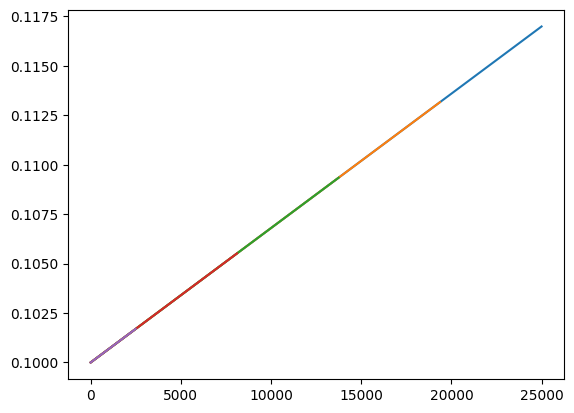

In [13]:
# sanity check
waves.reverse()
for i in waves:
    plt.plot(i)

In [14]:
# upload waveforms to instrument

# upload drive code
for channel in [chan["P1"], chan["P2"]]:
    seq = Sequence()
    seq.code = p_prog_code
    seq.waveforms = Waveforms()
    for i, wave in enumerate(waves):
        seq.waveforms[i] = wave.copy()

    channel.awg.load_sequencer_program(seq)
    channel.awg.write_to_waveform_memory(seq.waveforms)

    print(f"_________ {channel} _________")
    print(seq)
    
# upload with sequence code as the memory must be allocated first

# upload measure code
print(chan["measure"].generator.load_sequencer_program(readout_prog_code))

_________ /dev12158/sgchannels/1 _________
// Waveforms declaration
assignWaveIndex(placeholder(24992, false, false), 0);
assignWaveIndex(placeholder(19360, false, false), 1);
assignWaveIndex(placeholder(13744, false, false), 2);
assignWaveIndex(placeholder(8112, false, false), 3);
assignWaveIndex(placeholder(2496, false, false), 4);

// Reset the oscillator phase
resetOscPhase();

for (var i = 0; i < 5; i++) {
    // Trigger the scope
    waitDigTrigger(1);
    setTrigger(1);
    setTrigger(0);

    playZero(2496, AWG_RATE_250MHZ); // A
    executeTableEntry(i);  // B
    playZero(24992, AWG_RATE_250MHZ); // C
}

_________ /dev12158/sgchannels/2 _________
// Waveforms declaration
assignWaveIndex(placeholder(24992, false, false), 0);
assignWaveIndex(placeholder(19360, false, false), 1);
assignWaveIndex(placeholder(13744, false, false), 2);
assignWaveIndex(placeholder(8112, false, false), 3);
assignWaveIndex(placeholder(2496, false, false), 4);

// Reset the oscillator phase
resetOscPha

#### Verify sequences

In [15]:
loaded_waveforms = chan["P1"].awg.read_from_waveform_memory()

loaded_waveforms.validate(chan["P1"].awg.waveform.descriptors())

#### Setup command tables
**TODO**: Rewrite this into a function that takes the channel name

In [16]:
# COMMAND TABLES

def cmdtable(ct, amplitude, length, wave_index, ct_index):
    """
    Load a default command table with a sin/cos wave (used throughout the documentation)
    """
    ct.table[ct_index].waveform.index = wave_index
    ct.table[ct_index].amplitude00.value = amplitude  # all in dBm
    ct.table[ct_index].amplitude01.value = -amplitude
    ct.table[ct_index].amplitude10.value = amplitude
    ct.table[ct_index].amplitude11.value = amplitude
    ct.table[ct_index].waveform.length = length  # in samples
    ct.table[ct_index].waveform.samplingRateDivider = samplingDivider  # inherit global


# each pulse needs its own command table
for channel in [chan["P1"], chan["P2"]]:
    schema = channel.awg.commandtable.load_validation_schema()
    ct = CommandTable(schema)

    #ct.active_valitation = True
    for wave_index in range(num_pulses):
        cmdtable(ct,
                 amplitude=voltToDbm(init_amp, channel.output.range()),
                 length=timeToSamples(init_len, samplingDivider),
                 wave_index=wave_index,
                 ct_index=wave_index,
                )
    channel.awg.commandtable.upload_to_device(ct)

In [17]:
loaded_waveforms

### Setup internal trigger

In [18]:
device.system.internaltrigger.repetitions(num_pulses)  # make sure that this matches how many pulses we are sending
device.system.internaltrigger.holdoff(init_len + 2*wait_and_settle + 100e-6*2)  # how long to wait between retriggers (increments of 100ns)



## Run

In [19]:
device.system.internaltrigger.enable(0)

result_node = chan["measure"].spectroscopy.result.data.wave
result_node.subscribe()

chan["measure"].spectroscopy.result.enable(1)  # start logger

# start sequencers
chan["measure"].generator.enable_sequencer(single=True)
chan["P1"].awg.enable_sequencer(single = 1)
#chan["P2"].awg.enable_sequencer(single = 1)

# start triggering sequence (which starts each sequencer)
device.system.internaltrigger.enable(1)

# wait for the measurement to complete
pbar = tqdm(total=num_pulses)
while device.system.internaltrigger.progress() != 1.0:
    p = int(device.system.internaltrigger.progress()*100)
    pbar.update(p-pbar.n)
    time.sleep(0.001)
pbar.update(100-pbar.n)
pbar.close()

chan["measure"].spectroscopy.result.enable(0)  # stop data logger

# get results
results = get_results(result_node, timeout=2)
result_node.unsubscribe()

acq = chan["measure"].spectroscopy.result.acquired()
if len(results) > acq:
    raise TimeoutError(f"Not all datapoints measured in the time provided. {acq} of {len(results)}.")

  0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
print(results)

[-0.00318793-0.01882236j -0.00318872-0.01881714j -0.00318508-0.01881835j
 -0.00319   -0.01882651j -0.00318586-0.01882539j]


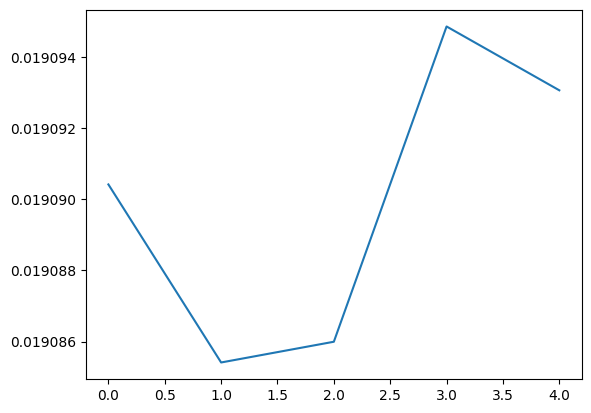

In [21]:
plt.plot(np.abs(results))

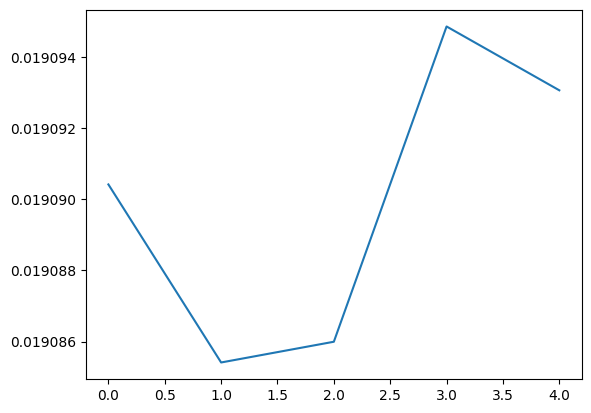

In [22]:
plt.plot(np.abs(results))